In [2]:
import numpy as np
from PIL import Image
from datetime import datetime
import os

def array_to_image(arr, show=True, save_path=None):
    """
    Chuyển NumPy array (float32, dạng [1, H, W] hoặc [H, W]) thành ảnh PIL.
    
    Parameters:
        arr (np.ndarray): Mảng đầu vào, giá trị float32 từ 0 đến 1.
        show (bool): Nếu True, hiển thị ảnh.
        save_path (str): Đường dẫn lưu ảnh nếu muốn, ví dụ: "output.png"
    
    Returns:
        PIL.Image.Image: Đối tượng ảnh PIL.
    """
    # Bỏ chiều dư thừa nếu có (ví dụ (1, H, W))
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = np.squeeze(arr, axis=0)

    # Chuẩn hóa về 0–255 và ép kiểu về uint8
    arr = (arr * 255).clip(0, 255).astype(np.uint8)

    # Tạo ảnh từ array
    img = Image.fromarray(arr)

    # Hiển thị ảnh nếu cần
    if show:
        img.show()

    # Tạo đường dẫn lưu nếu không cung cấp
    if save_path is None:
        now = datetime.now()
        timestamp = now.strftime("%Y%m%d_%H%M%S")
        filename = f"img_{timestamp}.png"
        save_path = os.path.join(os.getcwd(), filename)
    
    if save_path:
        img.save(save_path)

    return img


# Zero-shot object detection pipeline

In [3]:
from transformers import pipeline

f:\Anaconda\envs\pt_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


: 

In [ ]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [ ]:
predictions = detector(
    image,
    candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],
)
predictions

[{'score': 0.6007436513900757,
  'label': 'nasa badge',
  'box': {'xmin': 132, 'ymin': 348, 'xmax': 208, 'ymax': 423}},
 {'score': 0.5126088857650757,
  'label': 'nasa badge',
  'box': {'xmin': 278, 'ymin': 339, 'xmax': 329, 'ymax': 378}},
 {'score': 0.451993465423584,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': -1, 'xmax': 99, 'ymax': 505}},
 {'score': 0.29185882210731506,
  'label': 'rocket',
  'box': {'xmin': 352, 'ymin': 26, 'xmax': 465, 'ymax': 288}},
 {'score': 0.2252524346113205,
  'label': 'rocket',
  'box': {'xmin': 429, 'ymin': 40, 'xmax': 458, 'ymax': 260}},
 {'score': 0.20960113406181335,
  'label': 'star-spangled banner',
  'box': {'xmin': 7, 'ymin': 0, 'xmax': 512, 'ymax': 506}},
 {'score': 0.2048640251159668,
  'label': 'nasa badge',
  'box': {'xmin': 23, 'ymin': 330, 'xmax': 52, 'ymax': 384}},
 {'score': 0.1957497000694275,
  'label': 'rocket',
  'box': {'xmin': 395, 'ymin': -1, 'xmax': 438, 'ymax': 184}},
 {'score': 0.18185880780220032,
  'label': '

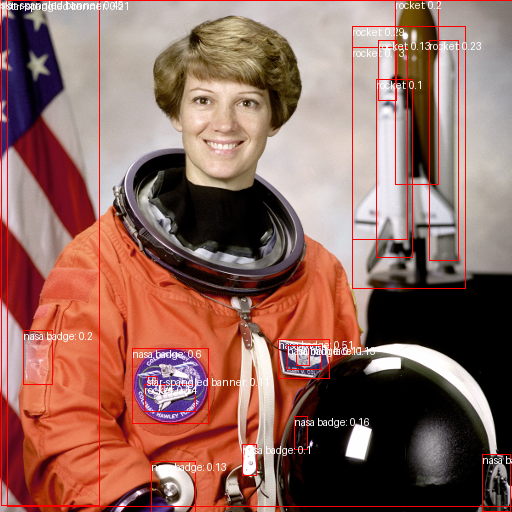

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")
    
image

# Text-prompted zero-shot object detection by hand

## Tải mô hình owlv2

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

## Tải mô hình SAM2

In [ ]:
!git clone https://github.com/facebookresearch/sam2.git

fatal: destination path 'sam2' already exists and is not an empty directory.


In [ ]:
# !bash download_ckpts.sh

/bin/bash: download_ckpts.sh: No such file or directory


In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, checkpoint)
sam2_predictor = SAM2ImagePredictor(sam2_model)

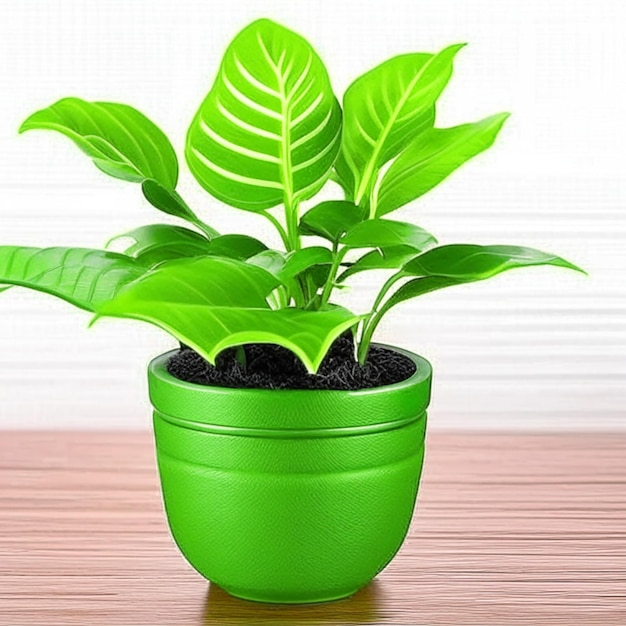

In [ ]:
import requests

# url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
url = "https://img.freepik.com/premium-photo/potted-plant_920207-9698.jpg"
ori_image = Image.open(requests.get(url, stream=True).raw)
ori_image

In [ ]:
text_queries = ["potted", "plant"]
# the image processor resized images before feeding them to the model
inputs = processor(text=text_queries, images=ori_image, return_tensors="pt")

In [ ]:
import torch
import copy
from PIL import ImageDraw
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([ori_image.size[::-1]])
    # use the post_process_object_detection() method to make sure the predicted bounding boxes have the correct coordinates relative to the original image
    results = processor.post_process_grounded_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]


In [ ]:
im = ori_image.copy()
draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="yellow")
im.show()

In [ ]:

scores = results["scores"]
labels = results["labels"]
boxes = results["boxes"]

threshold = 0.4
valid_boxes = boxes[scores > threshold].cpu().numpy()
valid_labels = [text_queries[label] for label, score in zip(labels, scores) if score > threshold]

In [ ]:
import numpy as np
import cv2

# Tải hình ảnh vào SAM 2
sam2_predictor.set_image(np.array(ori_image.convert("RGB")))

masks, scores, logits = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=valid_boxes,
    multimask_output=False,
)

In [ ]:
import copy
from PIL import Image, ImageDraw

# Tạo bản sao ảnh
im = ori_image.copy()
draw = ImageDraw.Draw(im)

# Tạo layer mặt nạ rỗng
mask_layer = Image.new("RGBA", im.size, (0, 0, 0, 0))  # layer chứa các mask

for box, score, label, mask in zip(boxes, scores, labels, masks):
    # Vẽ bounding box
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin - 15), f"{text_queries[label]}: {round(score.item(), 2)}", fill="black")

    # Vẽ mặt nạ lên layer phụ
    mask = mask[0]  # (H, W)
    mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
    mask_draw = ImageDraw.Draw(mask_layer)
    mask_draw.bitmap((0, 0), mask_image, fill=(0, 250, 0, 120))

# Gộp ảnh mask với ảnh chính
im = Image.alpha_composite(im.convert("RGBA"), mask_layer).convert("RGB")

# Hiển thị hoặc lưu
im.show()

now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
filename = f"owlv2_sam2_{timestamp}.png"
im.save(filename)


NameError: name 'ori_image' is not defined